In [ ]:
#importing libraries
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
import random
from PIL import ImageDraw, ImageFont, Image
import torch
import numpy as np
import zipfile
import os
from pathlib import Path
from tqdm import tqdm
from datasets import Dataset, Image
from datasets import load_metric
import matplotlib.pyplot as plt
import pandas as pd

Creating dataset of images and labels

In [ ]:
image_dict = {}
# Define the list of file names
file_names = []
labels = []

In [ ]:
for file in sorted((Path('C:/Users/Admin/bird_species').glob('*/*/*.jpg'))):
    file_names.append(str(file))
    label = str(file).split('\\')[-2]
    labels.append(label)
print(len(file_names), len(labels))

dataset = Dataset.from_dict({"image": file_names, "label": labels}).cast_column("image", Image())

89885 89885


In [ ]:
# example of image
ex = dataset[299]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 'BANDED BROADBILL'}

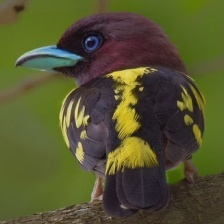

In [ ]:
ex['image']

In [ ]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 89885
})

In [ ]:
# getting ids for the labels
labels_list = list(set(labels))
label_to_id, id_to_label = dict(), dict()
for i, label in enumerate(labels_list):
    label_to_id[label] = i
    id_to_label[i] = label

print(id_to_label, '\n\n', label_to_id)

{0: 'ALBATROSS', 1: 'SMITHS LONGSPUR', 2: 'MILITARY MACAW', 3: 'PALM NUT VULTURE', 4: 'BLUE THROATED PIPING GUAN', 5: 'GRAY CATBIRD', 6: 'WHITE TAILED TROPIC', 7: 'HELMET VANGA', 8: 'JAVA SPARROW', 9: 'CACTUS WREN', 10: 'GAMBELS QUAIL', 11: 'MANGROVE CUCKOO', 12: 'PARAKETT  AUKLET', 13: 'WILLOW PTARMIGAN', 14: 'VERDIN', 15: 'BARN OWL', 16: 'SORA', 17: 'YELLOW CACIQUE', 18: 'ORANGE BRESTED BUNTING', 19: 'KAKAPO', 20: 'SCARLET TANAGER', 21: 'BLOOD PHEASANT', 22: 'RED HEADED DUCK', 23: 'BLACK SWAN', 24: 'GREAT POTOO', 25: 'WHITE CHEEKED TURACO', 26: 'BANDED STILT', 27: 'VERMILION FLYCATHER', 28: 'COMMON STARLING', 29: 'CAPUCHINBIRD', 30: 'GREATER PRAIRIE CHICKEN', 31: 'LARK BUNTING', 32: 'NICOBAR PIGEON', 33: 'AZURE BREASTED PITTA', 34: 'CAPE LONGCLAW', 35: 'SCARLET CROWNED FRUIT DOVE', 36: 'AFRICAN EMERALD CUCKOO', 37: 'AFRICAN CROWNED CRANE', 38: 'GREATOR SAGE GROUSE', 39: 'HAMERKOP', 40: 'DOUBLE EYED FIG PARROT', 41: 'BAND TAILED GUAN', 42: 'BLACK NECKED STILT', 43: 'CHUKAR PARTRIDGE',

Splitting data into train, test and validation

In [ ]:
print(dataset.shape)

(89885, 2)


In [ ]:
# getting train data
dataset = dataset.train_test_split(test_size=0.4)
train_data = dataset['train']
test_val= dataset['test']
# getting test and validation
test_val = test_val.train_test_split(test_size = 0.5)
test_data = test_val['train']
val_data = test_val['test']
print(train_data.shape, test_data.shape, val_data.shape)

(53931, 2) (17977, 2) (17977, 2)


Preparing our images for the model.

First download ViT image processor. ViT image processor initialized with a configuration that was saved along with the pretrained model we plan to use. We will use the google/vit-base-patch16-224-in21k model.

In [ ]:
# loading processor
model_name = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name)

In [ ]:
processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Processing data

In [ ]:
# creating data to transform function as a batch
def transform(example_batch):
    # taking a list of PIL images and turn them to pixel values
    inputs = processor([x for x in example_batch['image']], return_tensors='pt')

    # including the labels!
    inputs['labels'] = [label_to_id[x] for x in example_batch["label"]]
    return inputs


In [ ]:
prepared_train = train_data.with_transform(transform)
prepared_test = test_data.with_transform(transform)
prepared_val = val_data.with_transform(transform)

In [ ]:
# getting an example of processed data
prepared_train[0]

{'pixel_values': tensor([[[ 0.2235,  0.2392,  0.2392,  ...,  0.4745,  0.4745,  0.4667],
          [ 0.2471,  0.2471,  0.2471,  ...,  0.4824,  0.4824,  0.4824],
          [ 0.2549,  0.2549,  0.2471,  ...,  0.4824,  0.4824,  0.4824],
          ...,
          [ 0.3176,  0.3255,  0.3255,  ...,  0.1843,  0.1843,  0.1765],
          [ 0.3333,  0.3333,  0.3333,  ...,  0.1765,  0.1765,  0.1765],
          [ 0.3255,  0.3255,  0.3255,  ...,  0.1608,  0.1686,  0.1843]],
 
         [[ 0.2549,  0.2706,  0.2706,  ...,  0.4510,  0.4510,  0.4431],
          [ 0.2784,  0.2784,  0.2784,  ...,  0.4588,  0.4588,  0.4588],
          [ 0.2941,  0.2941,  0.2863,  ...,  0.4588,  0.4588,  0.4588],
          ...,
          [ 0.3412,  0.3490,  0.3490,  ...,  0.1843,  0.1765,  0.1686],
          [ 0.3647,  0.3647,  0.3725,  ...,  0.1765,  0.1608,  0.1608],
          [ 0.3569,  0.3569,  0.3569,  ...,  0.1608,  0.1529,  0.1686]],
 
         [[-0.2235, -0.2078, -0.1922,  ...,  0.1922,  0.1922,  0.1843],
          [-

Training and Evaluation

The training pipline

- Define a collate function.

- Define an evaluation metric. During training, the model should be evaluated on its prediction accuracy.

- Load a pretrained checkpoint. You need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.


Defining the collator

In [ ]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

Defining an evaluation matrix

In [ ]:
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

C:\Users\Admin\AppData\Local\Temp\ipykernel_6048\3314281577.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


Loading the pretrained model

In [ ]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels_list),
    id2label = id_to_label,
    label2id = label_to_id
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Setting up training configuration

In [ ]:
# defining training arguments
training_args = TrainingArguments(
  output_dir="vit_bird_species",
  logging_dir='logs',
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=2,
  weight_decay=0.02,
  warmup_steps=50,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=processor,
)

Training

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Step,Training Loss,Validation Loss,Accuracy
100,5.715900,5.684092,0.432441
200,4.850100,4.811745,0.664015
300,4.016200,3.949115,0.744451
400,3.148100,3.097470,0.802970
500,2.398600,2.360487,0.832453
600,1.770400,1.746042,0.862213
700,1.330300,1.277068,0.888914
800,0.999600,0.948569,0.904712
900,0.775800,0.747808,0.923625
1000,0.543500,0.581741,0.926795


***** train metrics *****
  epoch                    =          2.0
  total_flos               = 7820963815GF
  train_loss               =       0.9704
  train_runtime            =  18:38:10.26
  train_samples_per_second =        1.608
  train_steps_per_second   =         0.05


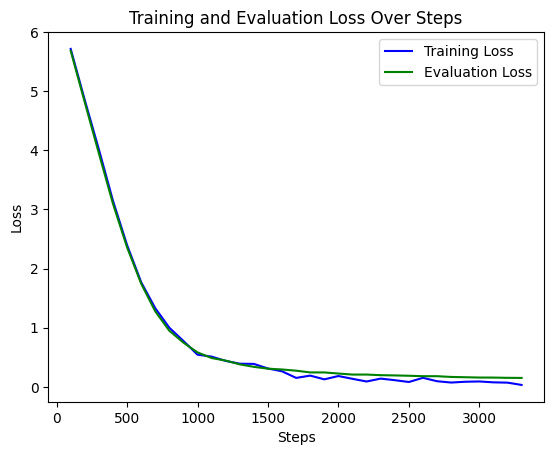

In [ ]:
data = pd.read_csv('train_results.csv')

# Create a line plot for training loss
plt.plot(data['Step'], data['Training Loss'], label='Training Loss', color='blue')

# Create a line plot for evaluation
plt.plot(data['Step'], data['Validation Loss'], label='Evaluation Loss', color='green')

# Add labels and a title
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss Over Steps')

# Add a legend
plt.legend()

# Show the plot
#plt.grid()
plt.show()

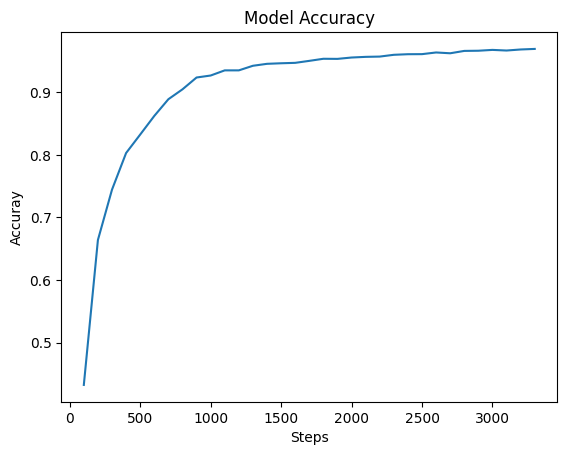

In [ ]:
# Create a line plot
plt.plot(data['Step'], data['Accuracy'], label='Line Plot')

# Add labels and a title
plt.xlabel('Steps')
plt.ylabel('Accuray')
plt.title('Model Accuracy')

# Add a legend
#plt.legend()

# Show the plot
plt.show()

In [ ]:
log_history = pd.DataFrame(trainer.state.log_history)
log_history = log_history.fillna(0)
log_history

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,6.2634,4.000000e-05,0.01,10,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.00,0.000000e+00,0.000000
1,6.2466,8.000000e-05,0.01,20,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.00,0.000000e+00,0.000000
2,6.2332,1.200000e-04,0.02,30,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.00,0.000000e+00,0.000000
3,6.1728,1.600000e-04,0.02,40,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.00,0.000000e+00,0.000000
4,6.1119,2.000000e-04,0.03,50,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366,0.0622,2.046960e-06,1.98,3340,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.00,0.000000e+00,0.000000
367,0.0536,1.444913e-06,1.99,3350,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.00,0.000000e+00,0.000000
368,0.0946,8.428657e-07,1.99,3360,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.00,0.000000e+00,0.000000
369,0.0982,2.408188e-07,2.00,3370,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.00,0.000000e+00,0.000000


Evaluation

In [ ]:
trainer.evaluate()

{'eval_loss': 0.15017764270305634,
 'eval_accuracy': 0.9692940980141291,
 'eval_runtime': 1423.4894,
 'eval_samples_per_second': 12.629,
 'eval_steps_per_second': 1.579,
 'epoch': 2.0}

Loading the model and processor

In [ ]:
# Loading trained model
model = ViTForImageClassification.from_pretrained('vit_bird_species')

# Loading processor
processor = ViTImageProcessor.from_pretrained('vit_bird_species')

Prediction

Example 1

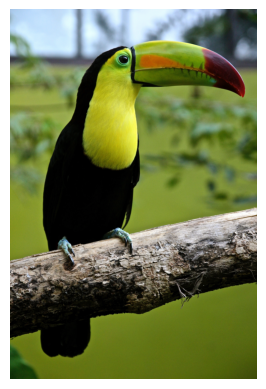

In [ ]:
from PIL import Image
# getting test image
test_image = Image.open('images/pexels-carlos-spitzer-17811.jpg')

# Display the image using Matplotlib
plt.imshow(test_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [ ]:
# processing the test image
inputs = processor(images=test_image, return_tensors="pt")

# Making predictions while temporarily disabling gradient computation
model.eval()  # Setting the model to evaluation mode (e.g., for dropout layers)
with torch.no_grad():  # Enter the no_grad context
    predictions = model(**inputs)  # Perform inference

In [ ]:
# getting the logits
logits = predictions.logits

In [ ]:
# getting the class index with the highest probability
class_indices = int(torch.argmax(logits, dim=1))
# printing the label
print(model.config.id2label[class_indices])

TOUCHAN


Example 2

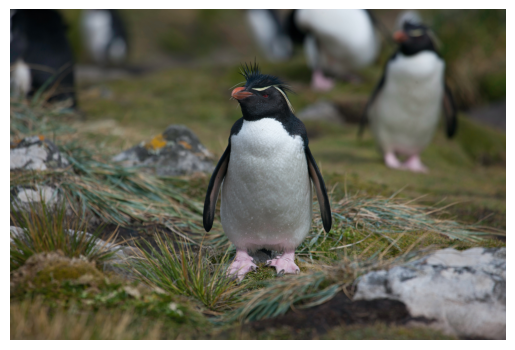

In [ ]:
# getting test image
test_image = Image.open('images/pexels-jack-salen-724695.jpg')

# Display the image using Matplotlib
plt.imshow(test_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [ ]:
# processing the test image
inputs = processor(images=test_image, return_tensors="pt")

# Making predictions while temporarily disabling gradient computation
model.eval()  # Setting the model to evaluation mode (e.g., for dropout layers)
with torch.no_grad():  # Enter the no_grad context
    predictions = model(**inputs)  # Perform inference

In [ ]:
# getting the logits
logits = predictions.logits
# getting the class index with the highest probability
class_indices = int(torch.argmax(logits, dim=1))
# printing the label
print(model.config.id2label[class_indices])

FIORDLAND PENGUIN


Ocra-mini-3b (open source LLM)

In [ ]:
from transformers import LlamaForCausalLM, LlamaTokenizer

In [ ]:
# loading the model and tokenizer
tokenizer = LlamaTokenizer.from_pretrained("psmathur/orca_mini_3b")
model = LlamaForCausalLM.from_pretrained("psmathur/orca_mini_3b")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
prompt = "Write about FIORDLAND PENGUIN"

In [ ]:
tokens = tokenizer.encode(prompt)
tokens = torch.LongTensor(tokens).unsqueeze(0)
#tokens = tokens.to(device)

In [ ]:
instance = {'input_ids': tokens,'top_p': 1.0, 'temperature':0.2, 'generate_len': 150, 'top_k': 30}

In [ ]:
length = len(tokens[0])
with torch.no_grad():
  response = model.generate(
              input_ids=tokens,
              max_length=length+instance['generate_len'],
              top_p=instance['top_p'],
              temperature=instance['temperature'],
              top_k=instance['top_k'],
              use_cache=True,
              do_sample=True,
        )

In [ ]:
output = response[0][length:]
output

tensor([   13,  1046, 28024,   559,   881,   283, 14840,   261,   322,   260,
         4392,   287,   283, 14840,   261,   342,   322,  1111,   288,   266,
          845, 31854, 19474,   285, 10387, 12665,   287,   760,  6743, 31843,
         1161,   397,   551,   287,   266,   829,  2620,   291,   758, 21734,
          283, 14840,   261,  4392,   288,   266,   924, 31843,   347, 28024,
          559,   881,   283, 14840,   261,   322,  1802,   329,   619, 15103,
         2490,   291,  2796, 27194,   501, 31844,   291,   619,  1239,  2491,
         1297, 31843,  1161,   397,  1111,   288,  1435, 21616,   328,   266,
        14623,   512,  8921,   291, 25789,   532, 19202,   781,   287,   266,
          845, 31854, 19474,   285, 10387, 12665,   287,   760,  6743, 31844,
         1224,  6269,  2044,  5461,  4483, 31844,  3172,  2044,  5461,  4483,
        31844,   291,   266,   476,   759,   692,  9605, 31843,   347, 28024,
          559,   881,   283, 14840,   261,   322,   260,  3721, 

In [ ]:
result = tokenizer.decode(output, skip_special_tokens=True)
result

'\nThe Fiordland penguin is a species of penguin that is found in the sub-Antarctic islands of New Zealand. They are one of the rarest and most endangered penguin species in the world. The Fiordland penguin is known for its distinctive black and white plumage, and its slender build. They are found in small colonies on the steep cliffs and rocky outcrops of the sub-Antarctic islands of New Zealand, including Little Barrier Island, Great Barrier Island, and the Kermadecs. The Fiordland penguin is a highly adapted swimmer, and is able to dive to depths of up to 500 feet to catch fish'